In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvas
from scipy.spatial import distance
import random
import pickle
from scipy import stats


# allow us to re-use the framework from the src directory
import sys, os
sys.path.append(os.path.abspath(os.path.join('../')))

import max_ent.examples.grid_9_by_9 as G
from max_ent.utility.support import *
from max_ent.gridworld import Directions


random.seed(123)
np.random.seed(123)

In [59]:
def plot_results(df, x, y):
    fig=plt.figure(figsize=(12, 7))
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.set_theme(style="whitegrid")
    sns.set(font_scale=2)
    sns.color_palette("viridis", as_cmap=True)
    #g=sns.lineplot(x=x, y=y, data=df, hue="type",markers=True, dashes=False)
    g = sns.barplot(x=x, y=y, hue="type", data=df.loc[(df['type']!="const")& (df['type']!="s1") & (df['type']!="s2")], palette="autumn", ci=95);
    #g.set_xticklabels([f"({(i)/10:0.1f}, {1 - (i)/10:0.1f})" for i in range(11)])
    
    constrained_line = df.loc[(df['type']=="const")][y].values[0]
    s1_line = df.loc[(df['type']=="s1")][y].values[0]
    s2_line = df.loc[(df['type']=="s2")][y].values[0]
    
    g.axhline(constrained_line, color='r', linestyle='--', label="Constrained")
    g.axhline(s1_line, color='b', linestyle='--', label="S1")

    g.axhline(s2_line, color='g', linestyle='-.', label="S2")

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(label=y+" varying "+x)
    
    plt.legend()
    plt.grid(alpha=0.3)
    #g.set_xticks(range(11)) # <--- set the ticks first

    #plt.xlabel("W(Nominal, Constraints)")
    #plt.ylabel("Avg JS dist")
    plt.show()
    fig.savefig(os.path.join("./", f"{y}_varying_{x}.png"), bbox_inches = 'tight')

In [60]:
from mc.self import *
from mc.system1 import *
from mc.system2 import *
from mc.mca import *

def build_dict(temp_matrix, type_mca, s1_usage=0,  t1=0, t2=0, t3=0, t4=0, t6=0, t7=0):
    temp_dict={}
    temp_dict['type']= type_mca
    temp_dict['Length']= temp_matrix[1]
    temp_dict['Reward']= temp_matrix[2]
    temp_dict['Viol'] = temp_matrix[4]
    temp_dict['S1_Usage'] = s1_usage
    temp_dict['t1'] = t1
    temp_dict['t2'] = t2
    temp_dict['t3'] = t3
    temp_dict['t4'] = t4
    temp_dict['t6'] = t6
    temp_dict['t7'] = t7
    temp_df = pd.DataFrame(data=temp_dict, index=[0])
    
    return temp_df
    

def simulation(n_cfg, c_cfg, demo, constraints, n_trajectories=200, 
               threshold1 = [200], threshold2 = [0.5], threshold3 = [0.5], 
               threshold4 = [0.5], threshold6 = [1], threshold7 = [0.5], df=None):
    
    if df is None:
        df = pd.DataFrame()
   
    n=n_cfg.mdp
    c=c_cfg.mdp
    
    temp_matrix = count_states(demo.trajectories, c_cfg.mdp, n, constraints)
    temp_dict=build_dict(temp_matrix, type_mca='const')
    df = pd.concat([df, temp_dict])

    mca_s1 = MCA(n=n, c=c, demo=demo, only_s1=True)
    demo_mca_s1 = mca_s1.generate_trajectories(n_trajectories)
    temp_matrix_mca_s1 = count_states(demo_mca_s1.trajectories, c_cfg.mdp, n, constraints)
    temp_dict=build_dict(temp_matrix_mca_s1, type_mca='s1', s1_usage=mca_s1.getStatistics()[0])
    df = pd.concat([df, temp_dict])

    mca_s2 = MCA(n=n, c=c, demo=demo, only_s2=True)
    demo_mca_s2 = mca_s2.generate_trajectories(n_trajectories)
    temp_matrix_mca_s2 = count_states(demo_mca_s2.trajectories, c_cfg.mdp, n, constraints)
    temp_dict=build_dict(temp_matrix_mca_s2, type_mca='s2')
    df = pd.concat([df, temp_dict])
    
    for t1 in threshold1:
        for t2 in threshold2:
            for t3 in threshold3:
                for t4 in threshold4:
                    for t6 in threshold6:
                        for t7 in threshold7:
                            mca_10 = MCA(n=n, c=c, demo=demo, threshold1=t1, threshold2=t2, threshold3 = t3, threshold5 = 0, threshold6 = t6, threshold7 = t7)
                            demo_mca_10 = mca_10.generate_trajectories(n_trajectories)
                            temp_matrix_mca_10 = count_states(demo_mca_10.trajectories, c_cfg.mdp, n, constraints)
                            temp_dict=temp_dict=build_dict(temp_matrix_mca_10, type_mca='10', s1_usage=mca_10.getStatistics()[0], t1=t1, t2=t2, t3=t3, t4=t4, t6=t6, t7=t7)
                            df = pd.concat([df, temp_dict])


                            mca_01 = MCA(n=n, c=c, demo=demo, threshold1=t1, threshold2=t2, threshold3 = t3, threshold5 = 1, threshold6 = t6, threshold7 = t7)
                            demo_mca_01 = mca_01.generate_trajectories(n_trajectories)
                            temp_matrix_mca_01 = count_states(demo_mca_01.trajectories, c_cfg.mdp, n, constraints)
                            temp_dict=temp_dict=build_dict(temp_matrix_mca_01, type_mca='01', s1_usage=mca_01.getStatistics()[0], t1=t1, t2=t2, t3=t3, t4=t4, t6=t6, t7=t7)
                            df = pd.concat([df, temp_dict])

                            mca_02 = MCA(n=n, c=c, demo=demo, threshold1=t1, threshold2=t2, threshold3 = t3, threshold5 = 2, threshold6 = t6, threshold7 = t7)
                            demo_mca_02 = mca_02.generate_trajectories(n_trajectories)
                            temp_matrix_mca_02 = count_states(demo_mca_02.trajectories, c_cfg.mdp, n, constraints)
                            temp_dict=temp_dict=build_dict(temp_matrix_mca_02, type_mca='02', s1_usage=mca_02.getStatistics()[0], t1=t1, t2=t2, t3=t3, t4=t4, t6=t6, t7=t7)
                            df = pd.concat([df, temp_dict])
                                                         
                            
    return df

In [4]:
n_trials = 5 #

n_trajectories = 10

threshold1 = 200 # {10, 50, 100, 200, 300} default 200
threshold2 = 0.8 # {0, 0.2, 0.4, 0.6, 0.8, 1} default 0.5
threshold3 = 0.6 # {0, 0.2, 0.4, 0.6, 0.8, 1} default 0.5
threshold4 = 200 # {0, 0.2, 0.4, 0.6, 0.8, 1} default 0.5
threshold5 = 0 # means default w=[1,0]
threshold7 = 0.9 # {0, 0.2, 0.4, 0.6, 0.8, 1} default 0.5

df = pd.DataFrame()


In [5]:
## Set the grid
'''blue = [21,  9, 59,  1,  0, 20]
green = [42, 18, 76, 41, 23, 30]
cs = [63, 74, 13, 39, 48, 38]
ca = [Directions.DOWN_LEFT, Directions.UP_LEFT]
start =7
goal = 65

constraints = {'blue': blue, 'green': green, 'cs':cs, 'ca':ca}'''

{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x11890b518>}


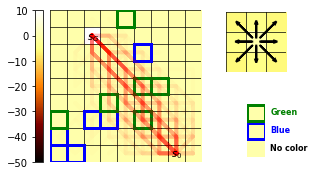

In [6]:

for i in range(n_trials):
    #generate constraints
    blue, green, cs, ca, start, goal = generate_constraints(9)
    constraints = {'blue': blue, 'green': green, 'cs':cs, 'ca':ca}
    
    #generate nomminal 
    n, n_cfg, demo_n, f1 = create_world('Nominal', blue, green, start=start, goal=goal)
    
    #generate constrained grid
    cc = [1, 2]
    c, c_cfg, demo_c, f2 = create_world('Constrained', blue, green, cs, ca, cc, start=start, goal=goal, check=True)

{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x11890b518>}


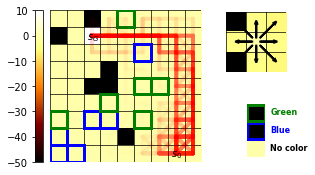

In [7]:
cc = [1, 2]
c, c_cfg, demo_c, f2 = create_world('Constrained', blue, green, cs, ca, cc, start=start, goal=goal, check=True)

In [8]:

'''threshold1 = 200 # {10, 50, 100, 200, 300} default 200
threshold2 = 0.5 # {0, 0.2, 0.4, 0.6, 0.8, 1} default 0.5
threshold3 = 0.5 # {0, 0.2, 0.4, 0.6, 0.8, 1} default 0.5
threshold4 = 0 # {0, 0.2, 0.4, 0.6, 0.8, 1} default 0.5
threshold5 = 0 # means default w=[1,0]
threshold7 = 0.9 # {0, 0.2, 0.4, 0.6, 0.8, 1} default 0.5

'''

In [61]:
import time

time_exp = int(round(time.time() * 1000))
df = simulation(n_cfg, c_cfg, demo_c, constraints, threshold1 = [10, 50, 100, 200, 300])
time_exp = int(round(time.time() * 1000)) - time_exp

print(time_exp)

/Users/aloreggia/Documents/GitHub/wmca/mc/self.py:237: RuntimeWarning: invalid value encountered in double_scalars
  return self.part_reward[state_s_coord] / self.getNTrajectories(state_s)


412120


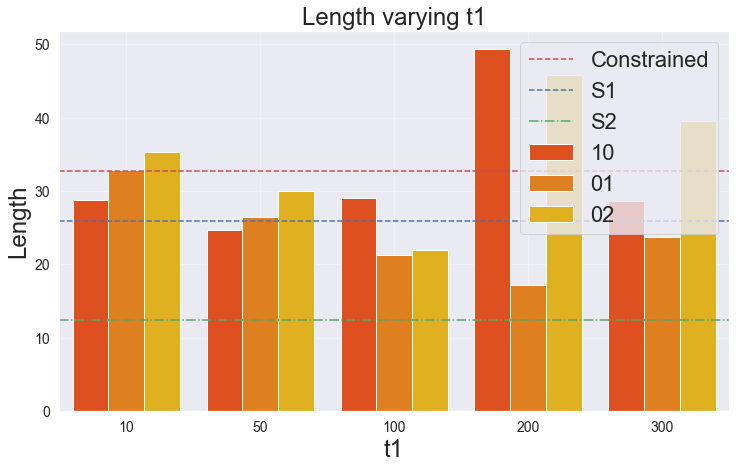

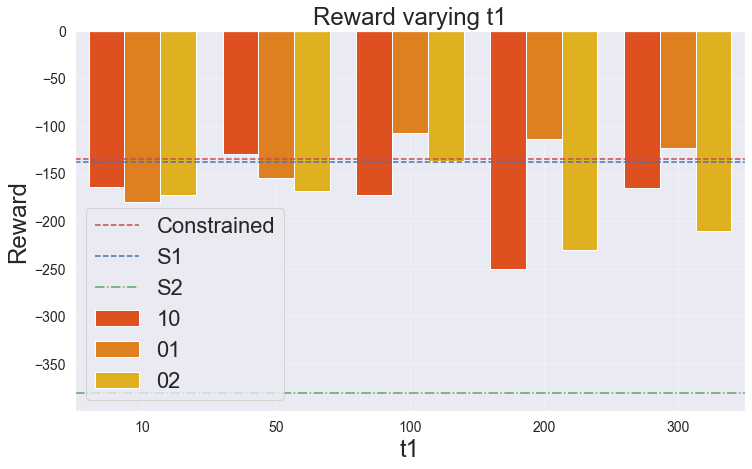

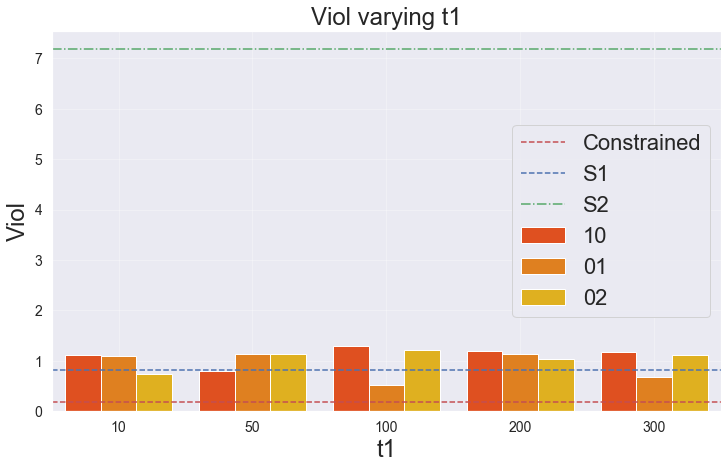

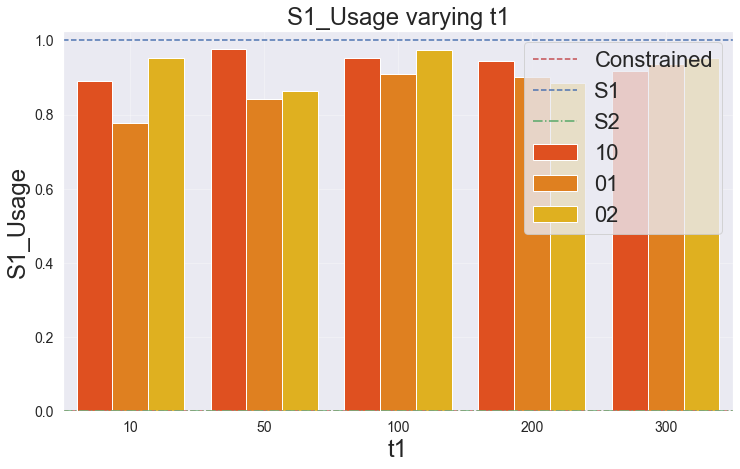

In [62]:
label_x = 't1'
plot_results(df,x=label_x,y='Length')
plot_results(df,x=label_x,y='Reward')
plot_results(df,x=label_x,y='Viol')
plot_results(df,x=label_x,y='S1_Usage')

/Users/aloreggia/Documents/GitHub/wmca/mc/self.py:237: RuntimeWarning: invalid value encountered in double_scalars
  return self.part_reward[state_s_coord] / self.getNTrajectories(state_s)


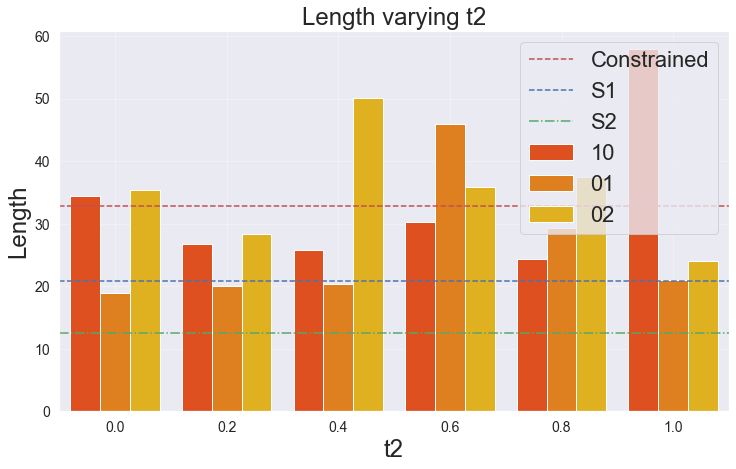

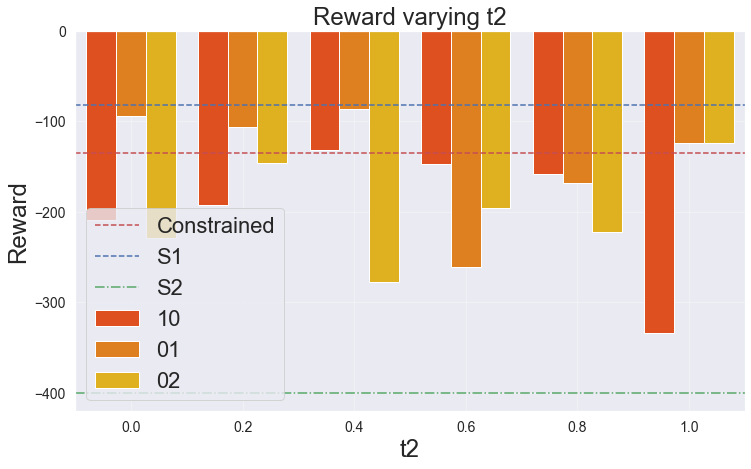

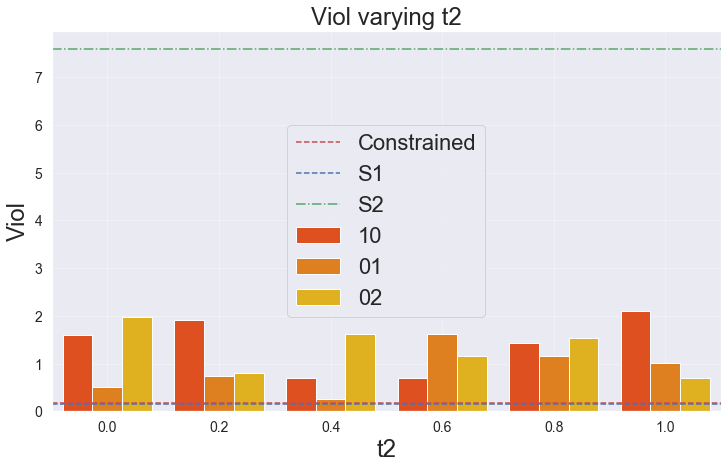

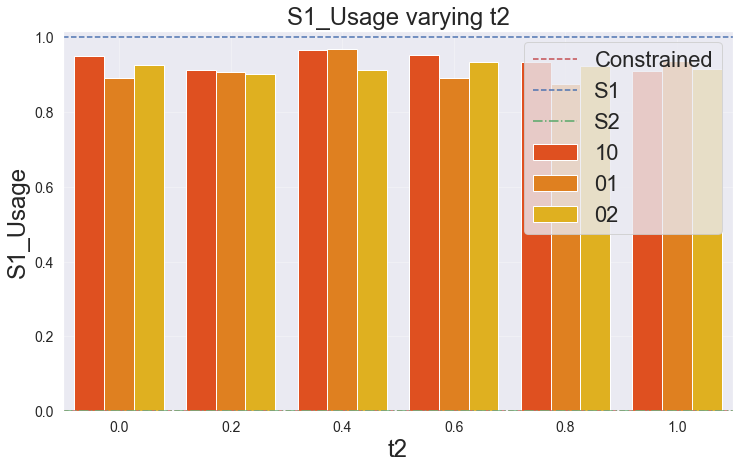

In [63]:
df2 = simulation(n_cfg, c_cfg, demo_c, constraints, threshold2 = [0, 0.2, 0.4, 0.6, 0.8, 1])
label_x = 't2'
plot_results(df2,x=label_x,y='Length')
plot_results(df2,x=label_x,y='Reward')
plot_results(df2,x=label_x,y='Viol')
plot_results(df2,x=label_x,y='S1_Usage')

/Users/aloreggia/Documents/GitHub/wmca/mc/self.py:237: RuntimeWarning: invalid value encountered in double_scalars
  return self.part_reward[state_s_coord] / self.getNTrajectories(state_s)


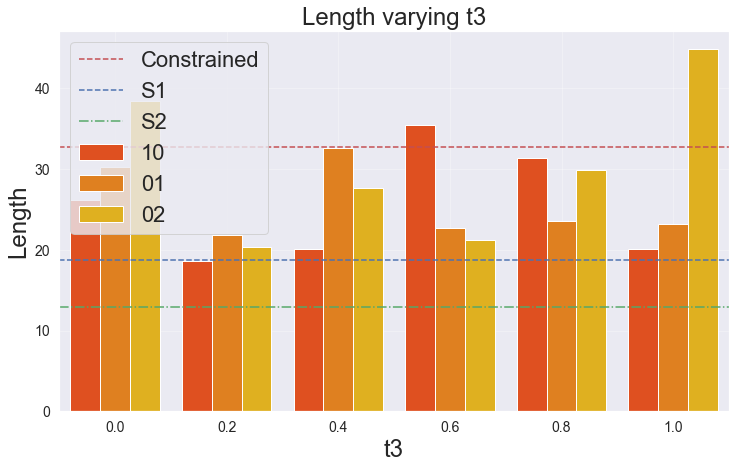

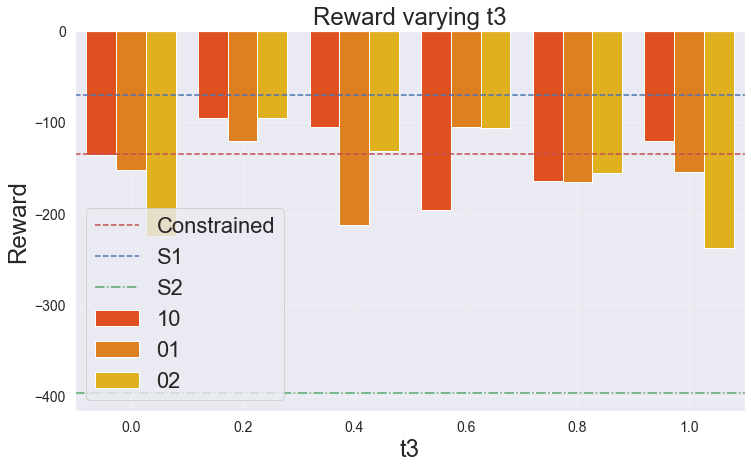

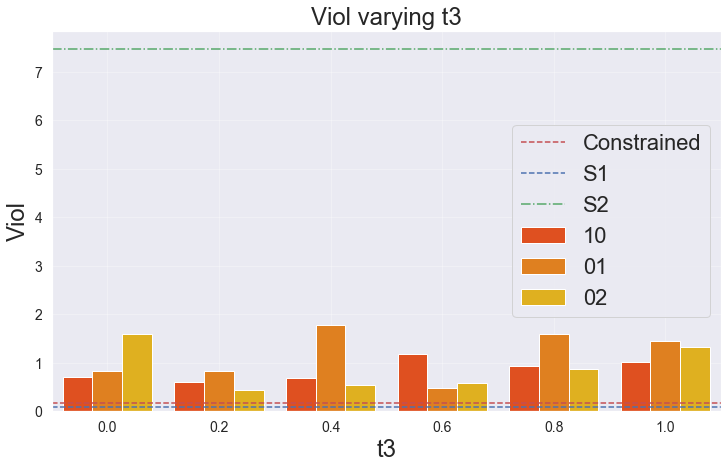

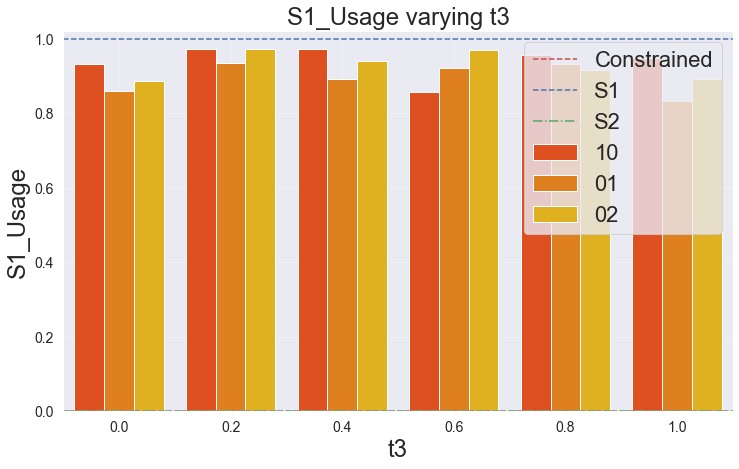

In [64]:
df3 = simulation(n_cfg, c_cfg, demo_c, constraints, threshold3 = [0, 0.2, 0.4, 0.6, 0.8, 1])
label_x = 't3'
plot_results(df3, x=label_x, y='Length')
plot_results(df3, x=label_x, y='Reward')
plot_results(df3, x=label_x, y='Viol')
plot_results(df3, x=label_x, y='S1_Usage')

/Users/aloreggia/Documents/GitHub/wmca/mc/self.py:237: RuntimeWarning: invalid value encountered in double_scalars
  return self.part_reward[state_s_coord] / self.getNTrajectories(state_s)


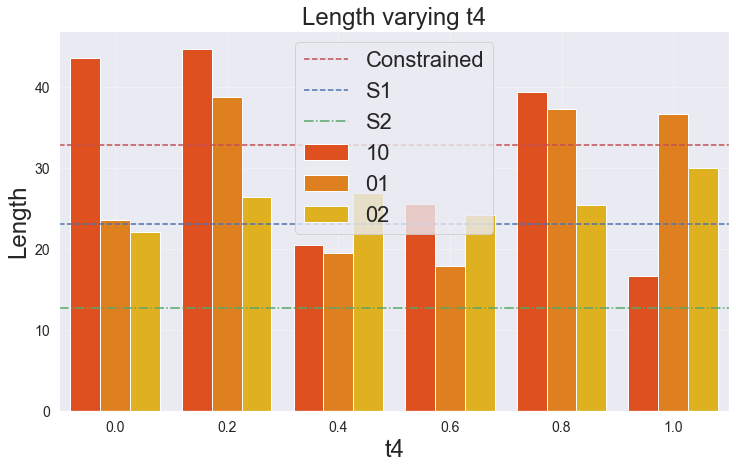

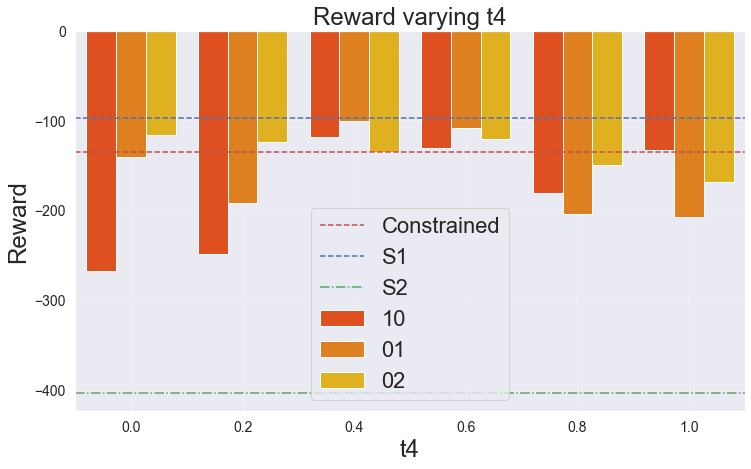

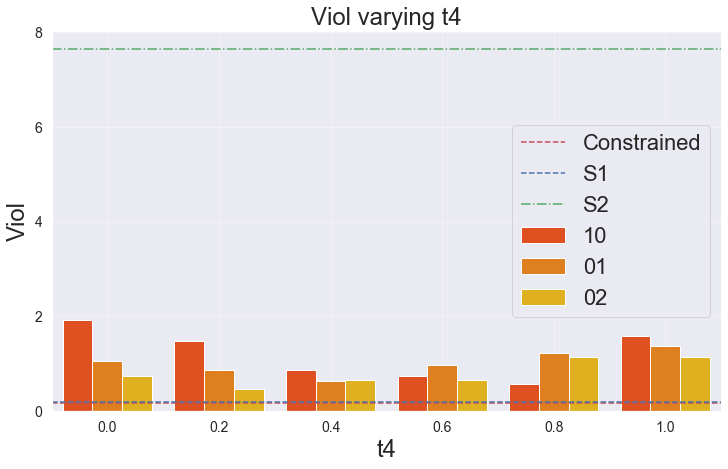

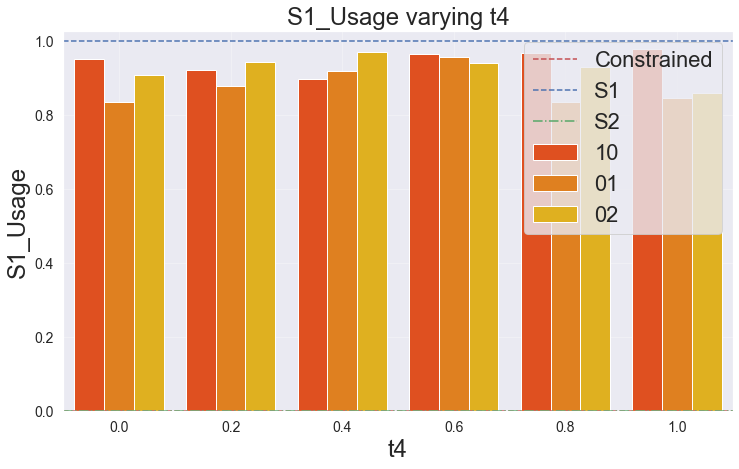

In [65]:
df4 = simulation(n_cfg, c_cfg, demo_c, constraints, threshold4 = [0, 0.2, 0.4, 0.6, 0.8, 1])
label_x = 't4'
plot_results(df4,x=label_x,y='Length')
plot_results(df4,x=label_x,y='Reward')
plot_results(df4,x=label_x,y='Viol')
plot_results(df4,x=label_x,y='S1_Usage')

/Users/aloreggia/Documents/GitHub/wmca/mc/self.py:237: RuntimeWarning: invalid value encountered in double_scalars
  return self.part_reward[state_s_coord] / self.getNTrajectories(state_s)


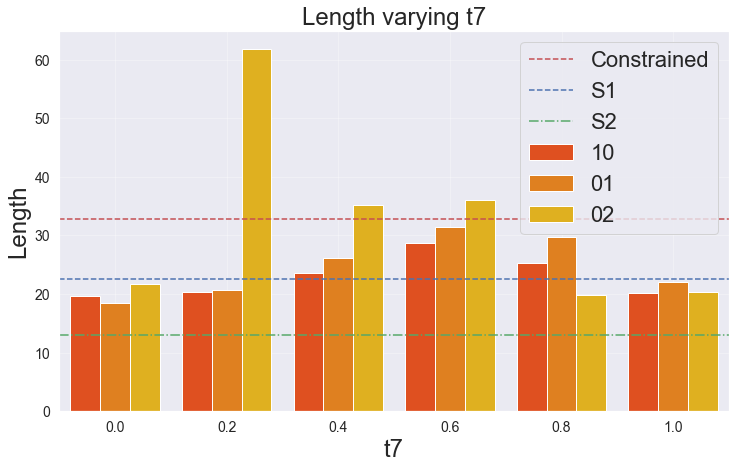

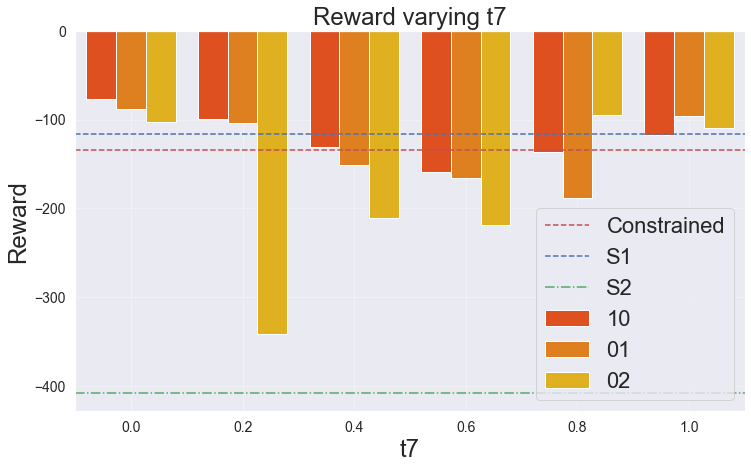

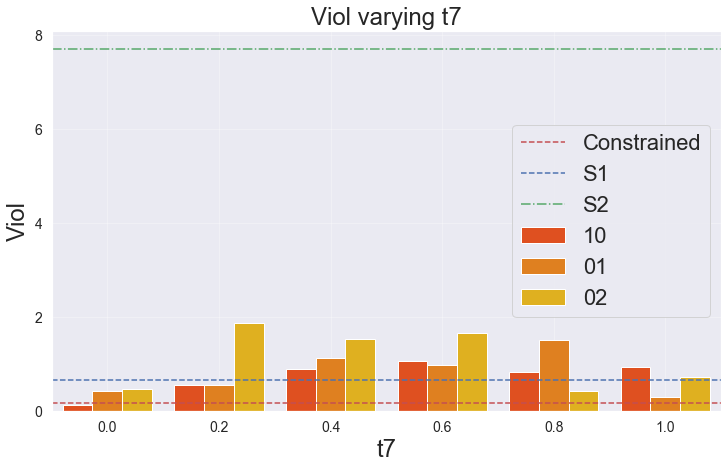

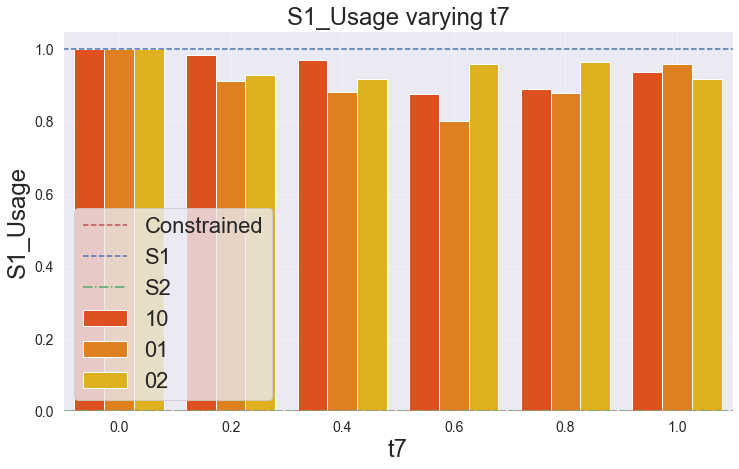

In [66]:
df7 = simulation(n_cfg, c_cfg, demo_c, constraints, threshold7 = [0, 0.2, 0.4, 0.6, 0.8, 1])
label_x = 't7'
plot_results(df7,x=label_x,y='Length')
plot_results(df7,x=label_x,y='Reward')
plot_results(df7,x=label_x,y='Viol')
plot_results(df7,x=label_x,y='S1_Usage')

In [58]:
df

,type,Length,Reward,Viol,S1_Usage,t1,t2,t3,t4,t6,t7
0,const,32.770,-134.560319,0.175,0.000000,0,0.0,0.0,0.0,0,0.0
0,s1,23.590,-103.351547,0.295,1.000000,0,0.0,0.0,0.0,0,0.0
0,s2,12.715,-387.061118,7.290,0.000000,0,0.0,0.0,0.0,0,0.0
0,10,22.385,-115.953515,0.705,0.964327,10,0.5,0.5,0.5,1,0.5
0,01,20.365,-114.598957,0.825,0.941809,10,0.5,0.5,0.5,1,0.5
0,02,30.420,-199.677661,1.715,0.914088,10,0.5,0.5,0.5,1,0.5
